### Download Data

In [1]:
import pandas as pd
import numpy as np
# read data to pandas frame
url = 'https://raw.githubusercontent.com/Dr-Ning-An/Deep-Learning-with-Keras/main/NonlinearRegression/Data.csv'
data = pd.read_csv(url)
data.shape
# print(data.head(5))

(10000, 4)

In [2]:
inputs = data.iloc[:, 0:2]
inputs_norm = (inputs - inputs.mean()) / inputs.std()
n_inputs_norm = inputs_norm.shape[1]
print(inputs_norm.head(5))
outputs = data.iloc[:, 2:4]
outputs_norm = (outputs - outputs.mean()) / outputs.std()
n_outputs_norm = outputs_norm.shape[1]
print(outputs_norm.head(5))

   Coordinate x [m]  Distributed load q [kN/m]
0          1.522223                  -1.407221
1         -1.420730                   1.508714
2         -0.901141                  -0.937512
3          0.314005                  -1.665284
4         -0.920193                   1.273167
   Displacement u [m]  Curvature kappa [m-1]
0            0.722879              -0.207977
1           -0.955251              -0.227143
2           -1.005059              -1.176568
3           -0.465783              -1.019123
4           -0.646611               0.090442


In [3]:
from sklearn.model_selection import train_test_split
# Randomly split the data into a training and test sets by holding 30% of the data for testing.
inputs_norm_train, inputs_norm_test, outputs_norm_train, outputs_norm_test = \
    train_test_split(inputs_norm, outputs_norm, test_size = 0.3, random_state=0)

In [4]:
import keras
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
# define regression model
def ANN_model():
    # create model
    model = Sequential()
    model.add(Dense(128, activation='tanh', input_shape=(n_inputs_norm,)))
    model.add(Dense(64, activation='tanh'))
    model.add(Dense(32, activation='tanh'))
    model.add(Dense(16, activation='tanh'))
    model.add(Dense(n_outputs_norm))
    
    # compile model
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [5]:
# build the model
model = ANN_model()

In [6]:
# fit the model
model.fit(inputs_norm_train, outputs_norm_train, epochs=200, batch_size=60)

Epoch 1/200
117/117 [==============================] - 2s 6ms/step - loss: 0.0718
Epoch 2/200
117/117 [==============================] - 1s 5ms/step - loss: 0.0060
Epoch 3/200
117/117 [==============================] - 1s 5ms/step - loss: 0.0019
Epoch 4/200
117/117 [==============================] - 1s 5ms/step - loss: 8.7716e-04
Epoch 5/200
117/117 [==============================] - 1s 5ms/step - loss: 5.1661e-04
Epoch 6/200
117/117 [==============================] - 1s 5ms/step - loss: 3.0595e-04
Epoch 7/200
117/117 [==============================] - 0s 4ms/step - loss: 2.1438e-04
Epoch 8/200
117/117 [==============================] - 1s 5ms/step - loss: 1.9739e-04
Epoch 9/200
117/117 [==============================] - 1s 6ms/step - loss: 1.4084e-04
Epoch 10/200
117/117 [==============================] - 1s 5ms/step - loss: 1.1521e-04
Epoch 11/200
117/117 [==============================] - 1s 4ms/step - loss: 1.0690e-04
Epoch 12/200
117/117 [==============================] - 1s 5ms/s

In [7]:
test_data = outputs_norm_test * outputs.std() + outputs.mean()
print(test_data)
test_data_disp = test_data.to_numpy()[:,0]
test_data_kappa = test_data.to_numpy()[:,1]

      Displacement u [m]  Curvature kappa [m-1]
9394            2.374574               9.334805
898             2.212246               9.747763
2398            2.851196              11.662809
5906           13.029009              20.449480
2343            6.448158              14.567710
...                  ...                    ...
4004           11.032060              19.409858
7375            3.926963               9.757329
9307           13.574592              20.677069
8394           12.160769              18.607801
5233            4.635886              13.574874

[3000 rows x 2 columns]


In [8]:
pred_data_norm = model.predict(inputs_norm_test)
pred_data_norm_df = pd.DataFrame(pred_data_norm, columns = ['Displacement u [m]','Curvature kappa [m-1]'])
pred_data_df = pred_data_norm_df * outputs.std() + outputs.mean()
print(pred_data_df)
pred_data_disp = pred_data_df.to_numpy()[:,0]
pred_data_kappa = pred_data_df.to_numpy()[:,1]

94/94 [==============================] - 0s 2ms/step
      Displacement u [m]  Curvature kappa [m-1]
0               2.381975               9.345537
1               2.215890               9.751204
2               2.853569              11.667773
3              13.002719              20.431468
4               6.437471              14.553743
...                  ...                    ...
2995           11.012983              19.405056
2996            3.931643               9.758343
2997           13.543140              20.655512
2998           12.150224              18.614196
2999            4.631457              13.564530

[3000 rows x 2 columns]


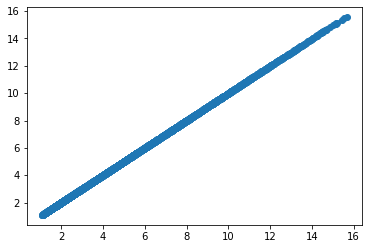

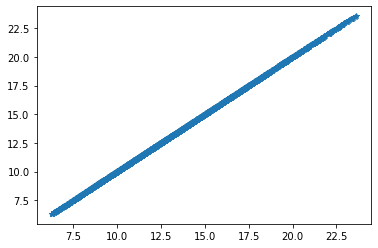

In [9]:
# Evaluate the mdoel on the test data and compare the error between predictions and true data
import matplotlib.pyplot as plt
plt.plot(test_data_disp, pred_data_disp, 'o')
plt.show()
plt.plot(test_data_kappa, pred_data_kappa, '*')
plt.show()

In [10]:
print(inputs.mean()[0])
print(inputs.std())

1.5000000000000002
Coordinate x [m]             0.288718
Distributed load q [kN/m]    0.288718
dtype: float64


In [11]:
import tensorflow as tf
def F_model(model,x_norm,q_norm):
    x_norm = tf.Variable(x_norm)
    q_norm = tf.Variable(q_norm)
    with tf.GradientTape() as g:
      g.watch(x_norm)
      with tf.GradientTape() as gg:
        gg.watch(x_norm)
        u_norm = model(tf.stack([x_norm,q_norm], axis=1))[:,0]
      du_norm_dx_norm = gg.gradient(u_norm, x_norm)  
    d2u_norm_dx_norm2 = g.gradient(du_norm_dx_norm, x_norm)  

    # Chain rule
    du_du_norm = outputs.std()[0]
    dx_norm_dx = 1/inputs.std()[0]
    d2u_dx2 =  du_du_norm *  d2u_norm_dx_norm2 * dx_norm_dx**2

    u = u_norm * outputs.std()[0] + outputs.mean()[0]

    return u, d2u_dx2

tf.Tensor(
[ 9.06644481  9.60675951 11.15333713 ... 30.13883411 15.131172
 13.10647546], shape=(3000,), dtype=float64)


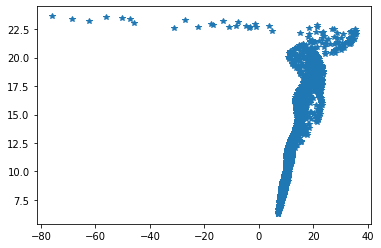

In [12]:
x_norm = inputs_norm_test.to_numpy()[:,0]
q_norm = inputs_norm_test.to_numpy()[:,1]
[u, d2u_dx2] = F_model(model, x_norm, q_norm)
print(d2u_dx2)
plt.plot(d2u_dx2, test_data_kappa, '*')
plt.show()